In [1]:
%load_ext autoreload
%autoreload 2

import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import birth_death_utils as bd
import os
from collections import Counter
from tqdm.notebook import tqdm
import pickle
from itertools import groupby
import pandas as pd
import yaml
import re
import multiprocessing as mp
import seaborn as sns

from sbi.analysis import pairplot
from sbi.inference import NPE, simulate_for_sbi, NLE
from sbi.utils import BoxUniform

from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

from torch import Tensor

# 1) Computation of summary statistics

In [2]:
def compute_summary_stats(g):
    """
    Generate a vector of summary statistics from a graph generated by birth-death simulation

    Parameters
    ----------
    g : nx.DiGraph()
        tree graph generated by birth_death_utils.ct_bd_tree
    
    Returns
    -------
    list
        vector of summary statistics characterizing a single tradition
    """
    n_living = list(nx.get_node_attributes(g, 'state').values()).count(True)

    if n_living == 0:
        return None
    
    if n_living == 1:
        return [1,0, -1,-1,-1,-1,-1,-1,-1]

    if n_living == 2:
        birth_times_trad = []
        for n in g.nodes():
            if g.nodes[n]['state']:
                birth_times_trad.append(g.nodes[n]['birth_time'])
        timelapse = int(max(birth_times_trad)-min(birth_times_trad))
        return [2, timelapse, -1,-1,-1,-1,-1,-1,-1]
    
    if n_living >= 3:
        birth_times_trad = []
        degrees = []
        direct_filiation_nb = 0
        arch_dists = []
        st = bd.generate_stemma(g)
        archetype = bd.root(st)

        for n in st.nodes():
            degrees.append(st.out_degree(n))

            if n != archetype:
                father = list(st.predecessors(n))[0]
                if st.nodes[n]['state'] and st.nodes[father]['state']:
                    direct_filiation_nb +=1
            if st.nodes[n]['state']:
                birth_times_trad.append(st.nodes[n]['birth_time'])
            arch_dists.append(len(nx.shortest_path(st, source=archetype, target=n)))
        
        timelapse = int(max(birth_times_trad)-min(birth_times_trad))
        deg_dist = Counter(degrees)
        deg1 = deg_dist[1]
        deg2 = deg_dist[2]
        deg3 = deg_dist[3]
        deg4 = deg_dist[4]
        depth = max(arch_dists)
        n_nodes = len(list(st.nodes()))

        return [
            n_living,
            timelapse,
            n_nodes,
            direct_filiation_nb,
            deg1,
            deg2,
            deg3,
            deg4,
            depth
        ]

# 2) Prepare empirical data

In this section we compute the summary statistics used for inference from the empirical data. These data are extracted from two different sources:
+ The OpenStemmata database
+ the table Old_French_witnesses for tradition consisting of less than 3 witnesses

these computation are essentially similar to those found in the analysis notebook

## a) From OpenStemmata

In [3]:
def convert_date(x):
    pattern1 = re.compile('[0-9][0-9][0-9][0-9]')
    pattern2 = re.compile('[0-9][0-9][0-9][0-9]-[0-9][0-9][0-9][0-9]')

    if bool(pattern1.fullmatch(x)):
        return int(x)
    if bool(pattern2.fullmatch(x)):
        xx = x.split('-')
        return (int(xx[0]),int(xx[1]))

def top(x):
    '''
    Upper bound on witness date (single year or range)
    '''
    match x:
        case (x1, x2):
            return x2
        case _:
            return x

def bottom(x):
    '''
    Lower bound on witness date (single year or range)
    '''
    match x:
        case (x1, x2):
            return x1
        case _:
            return x


def expected_abs_diff_degenerate(c, a, b):
    '''
    Returns the expectation value of the timelapse between one date given as range
    and one other as a single year
    '''
    if a == b:
        return abs(a - c)
    if a <= c <= b:
        return ((c-a)**2 + (b-c)**2) / (2*(b-a))
    elif c < a:
        return (a+b)/2 - c
    else: 
        return c - (a+b)/2

def expected_abs_diff(a, b, c, d):
    '''
    Return the expectation value of the timelapse between two dates given as
    intervals
    '''
    if a == b:
        return expected_abs_diff_degenerate(a, c, d)
    if c == d:
        return expected_abs_diff_degenerate(c, a, b)
    elif a < b < c < d:
        return (c+d-b-a)/2
    elif a <= c <= d < b:
        return (1/(b-a)) * ((1/2)*((d-a)*(c-a)+(b-d)*(b-c)) + (1/3)*(d-c)**2)
    elif a <= c <= b <= d:
        return (1/(b-a)) * ((1/2)* ((c-a)*(d-a) + (b-c)*(d-b)) + (1/(3*(d-c)))*(b-c)**3 )
    else:
        print(f"{a},{b} -- {c},{d} ")
        raise ValueError("Must have a < b, c < d, and a < c")

wholeCorpus = {}
corpus_dates = {}
for work in os.listdir(f'corpus_stemmata/'):
    print(f'{work}')
    st = bd.load_from_OpenStemmata(f'corpus_stemmata/{work}/stemma.gv')
    with open(f"corpus_stemmata/{work}/metadata.txt", 'r') as f:
        content = f.read()
    metadata = yaml.safe_load(content)
    if "wits" in metadata:
        dates = [wit["witOrigDate"] for wit in metadata['wits'] if wit["witOrigDate"] != '']
    else:
        dates = []

    dates_num = []
    for x in dates:
        if x != '':
            date_num = convert_date(x)
            if date_num != None:
                dates_num.append(date_num)
 
    wholeCorpus[f"{work}"] = st
    corpus_dates[f"{work}"] = dates_num

ranges_per_work = {}
for work, t_dates in corpus_dates.items():
    if t_dates != []:
        lb = sorted(t_dates, key=bottom)[0]
        ub = sorted(t_dates, key=top)[-1]
        ranges_per_work[work] = (lb,ub)


lifespans = {}
for w,v in ranges_per_work.items():
    match v:
        case [(a,b), (c,d)]:
            lifespans[w] = expected_abs_diff(a,b,c,d)
        case [(a,b), c]:
            lifespans[w] = expected_abs_diff_degenerate(a,b,c)
        case [c,(a,b)]:
            lifespans[w] = expected_abs_diff_degenerate(a,b,c)
        case [a,b]:
            lifespans[w] = abs(a-b)
        case _:
            print('error')

x_obs0 = {}
sizes = {}
for k in lifespans.keys():
    ## computation of observables
    g = wholeCorpus[k]

    n_living = list(nx.get_node_attributes(g, 'state').values()).count(True)
    sizes[k] = n_living
    degrees = []
    direct_filiation_nb = 0
    arch_dists = []

    if n_living >= 3:
        st = bd.generate_stemma(g)
        archetype = bd.root(st)
        for n in st.nodes():
            degrees.append(st.out_degree(n))

            if n != archetype:
                father = list(st.predecessors(n))[0]
                if st.nodes[n]['state'] and st.nodes[father]['state']:
                    direct_filiation_nb +=1
            arch_dists.append(len(nx.shortest_path(st, source=archetype, target=n)))
        
        timelapse = lifespans[k]
        deg_dist = Counter(degrees)
        deg1 = deg_dist[1]
        deg2 = deg_dist[2]
        deg3 = deg_dist[3]
        deg4 = deg_dist[4]
        depth = max(arch_dists)
        n_nodes = len(list(st.nodes()))

        x_obs0[k] = [
            n_living,
            4*int(timelapse),
            n_nodes,
            direct_filiation_nb,
            deg1,
            deg2,
            deg3,
            deg4,
            depth
        ]

Rochebouet_2021_RTroieProse5-2
Tyssens_1967_CharroiNimes
Rolin_1897_Aliscans1-Guillaume
Eusebi_1963_ChevOgierDanemarche
Zorn_1908_EnfViv
Tyssens_1967_PriseOrange
Alton_1889_MarquesRome
Karsch_1907_Gaydon
Ponceau_1997c_SaintGraal
Hult_2004_Charrette
Ruelle_1960_HuonBordeaux
Cloetta_1911_Moniage1
Blanchard_1976_TristanProseV1
Stimming_1920_BeuveHanstCont3-3
Tyssens_1967_MoniageRainouart2
Latour_1976_GuiBourgogne1
Tyssens_1967_ChevVivien
Thorpe_1992_Jerusalem
Sweetser_1964_Blancandin
Tyssens_1967_Guillaume
LeonardiTrachsler_2021_Meliadus1
Herbin_2018a_Anseys
Treutler_1880_Otinel
Gregory_1993_Cliges
Pope_1955_Thomas-Horn
Lagomarsini_2018_GuironCourtois1
Tyssens_1967_CourLouis
Jonin_1958_Yvain
Korte_1914_RenMont6
Ponceau_1997a_SaintGraal
Coco_2016_SeptSages-A
Rolin_1897_Aliscans2-Rainouart
Bedier_1902_Tristan
Myers_1981_Chetifs4
Rochebouet_2021_RTroieProse5-1
Bogdanow_1991_MortArtuPV
Tyssens_1967_EnfGuillaume
Veneziale_2020_Guiron-Cont
Braunholtz_1921_Horn
Myers_1981_Chetifs2
LePerson_2003_

## b) For texts without stemmata (with 1 or 2 witnesses)

In [4]:
df = pd.read_csv("Old_French_witnesses.csv")
f2_works = []
f1_works = []
works = set(list(df['text H-ID']))
size_frags_d = []
size_d = []
for work in works:
    n_wit = len(df[(df['text H-ID'] == work) & (df['status'] != 'fragment')])
    n_frags = len(df[(df['text H-ID'] == work) & (df['status'] == 'fragment')])
    if n_wit !=0:
        size_d.append(n_wit)
    if n_frags !=0:
        size_frags_d.append(n_frags)

    if n_wit == 2:
        f2_works.append(work)
    if n_wit == 1:
        f1_works.append(work)

size_dist = Counter(size_d)
size_dist_frags = Counter(size_frags_d)

In [5]:
f2_dates_0 = [df[(df["text H-ID"] == x) & (df['status'] != 'fragment')]["Date"].values.tolist() for x in f2_works]
f2_dates = [list(map(convert_date, x)) for  x in f2_dates_0]

ranges_per_work = []
for t_dates in f2_dates:
    if t_dates != []:
        lb = sorted(t_dates, key=bottom)[0]
        ub = sorted(t_dates, key=top)[-1]
        ranges_per_work.append((lb,ub))


lifespans_f2 = []
for v in ranges_per_work:
    match v:
        case [(a,b), (c,d)]:
            lifespans_f2.append(expected_abs_diff(a,b,c,d))
        case [(a,b), c]:
            lifespans_f2.append(expected_abs_diff_degenerate(a,b,c))
        case [c,(a,b)]:
            lifespans_f2.append(expected_abs_diff_degenerate(a,b,c))
        case [a,b]:
            lifespans_f2.append(abs(a-b))
        case _:
            print('error')

The summary statistics extracted from our two database are gathered and shuffled in a list ```x_obs_empirical``` of feature-vectors. The numbers of vectors corresponding to traditions with 1 or 2 witnesses added to the OpenStemmata is chosen so as to ensure that the median and relative proportions of tradition sizes for small tradition are the same as in the larger data corpus (contained in ```Old_French_witnesses.csv```)

In [6]:
add_f1 = [[
        1,
        0,
        -1,
        -1,
        -1,
        -1,
        -1,
        -1,
        -1] for k in range(61)]

add_f2 = [[2, int(4 * n), -1,-1,-1,-1,-1,-1,-1] for n in lifespans_f2]
x_obs_empirical = list(x_obs0.values()) + add_f1 + add_f2[:17]

random.shuffle(x_obs_empirical)

# 3) Simulation based inference --Training Neural Likelihood Estimator

In this section we perform the parameter inference using Simulation Based inference and more specifically the Neural Likelihood method as implemented in the ```sbi``` package. We take a uniform prior on a box ```[lambda_minx_prior, lambda_max_prior] * [mu_min_prior, mu_max_prior]```, and generate ```N_samples_prior``` simulations for each setting of the model.

*Note that pre-trained inference models are available in the ```inference_models``` folder*

In [3]:
lambda_min_prior = 4.*10**(-3)
lambda_max_prior = 9.*10**(-3)

mu_min_prior = 1.*10**(-3)
mu_max_prior = 5*10**(-3)

N_samples_prior = 50000 #500000
N_samples_posterior = 1000 #1000

## a) Joint model training

In [4]:
def simulator_base(theta):
    '''
    Wrapper function for the birth-death simulator
    '''
    l = theta[0]
    m = theta[1]
    return bd.generate_tree(l,m,1000,1000)

def simulator_decay(theta):
    '''
    Wrapper function for the birth-death simulator
    '''
    l = theta[0]
    m = theta[1]
    return bd.generate_tree_bd_decay(l,m,1000,1000)

def simulator_decim(theta):
    l = theta[0]
    m = theta[1]
    return bd.generate_tree_bd_decim(l,m,1000,1000,500)

def simulator(theta):
    lam, mu, m = theta
    m = int(torch.floor(m).item())

    if m == 0:
        x = simulator_base([lam, mu])
    elif m == 1:
        x = simulator_decay([lam, mu])
    elif m == 2:
        x = simulator_decim([lam, mu])
    else:
        raise ValueError("Invalid model index")

    return x    

prior_params = BoxUniform(low=Tensor([lambda_min_prior, mu_min_prior]), high=Tensor([lambda_max_prior, mu_max_prior]))
prior_model = BoxUniform(
    low=torch.tensor([0.0]),
    high=torch.tensor([2.999])  # ensures {0,1,2} after flooring
)

from sbi.utils import MultipleIndependent

prior = MultipleIndependent(
    [prior_params, prior_model]
)


In [9]:
theta0 = prior.sample((N_samples_prior,))

theta  = []
x = []

for t in tqdm(theta0):
    vec = compute_summary_stats(simulator(t))
    if vec != None:
        theta.append(list(t))
        x.append(vec)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [10]:
inference = NLE(prior=prior)
inference = inference.append_simulations(Tensor(theta), Tensor(x))
likelihood_estimator = inference.train()
with open("pretrained_models/inference_joint.pickle", "wb") as f:
    pickle.dump(inference, f)

 Neural network successfully converged after 218 epochs.

/tmp/ipykernel_112805/2353588036.py:5: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickle.dump(inference, f)


In [9]:
#load pretrained model serialized as pickle object

#with open("pretrained_models/inference_joint.pickle", "rb") as f:
#    inference = pickle.load(f)

In [13]:
posterior = inference.build_posterior(sample_with="rejection")

In [19]:
samples = posterior.sample(
    (N_samples_posterior,),
    x=x_obs_empirical
)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        may take a long time to collect the remaining 1000
                        samples. Consider interrupting (Ctrl-C) and switching to a
                        different sampling method with
                        `build_posterior(..., sample_with='mcmc')`. or
                        `build_posterior(..., sample_with='vi')`.


In [21]:
samples

tensor([[0.0065, 0.0027, 1.4828],
        [0.0067, 0.0027, 1.6090],
        [0.0063, 0.0026, 1.5511],
        ...,
        [0.0067, 0.0028, 1.4875],
        [0.0066, 0.0028, 1.5258],
        [0.0065, 0.0027, 1.5748]])

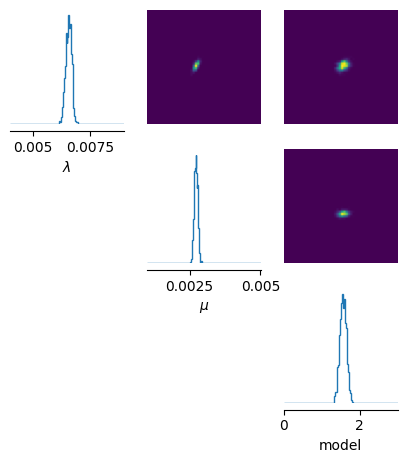

In [23]:
_ = pairplot(
    samples,
    limits=[[lambda_min_prior, lambda_max_prior], [mu_min_prior, mu_max_prior], [0,3]],
    figsize=(5, 5),
    labels=[r"$\lambda$", r"$\mu$", r"model"]
)

/tmp/ipykernel_112805/245841850.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_samples['model'], hist=True, kde=True,


<Axes: xlabel='model', ylabel='Density'>

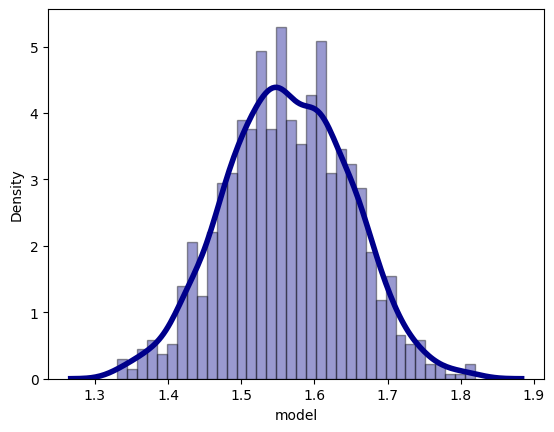

In [26]:
df_samples = pd.DataFrame({'lambda':[x[0] for x in samples.tolist()], 'mu':[x[1] for x in samples.tolist()], 'model':[x[2] for x in samples.tolist()]})
#sns.kdeplot(data=df_samples, x='lambda', y='mu', fill=True)
#sns.kdeplot(data=df_samples, x='lambda', y='model', fill=True)
sns.distplot(df_samples['model'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

## b) Model checks
Here, we simulate traditions for each model, and look at the model ability to distinguish them.

In [29]:
def p_m_given_x_lambda_mu(x_obs, lam, mu):
    x_obs = torch.as_tensor(x_obs, dtype=torch.float32)

    # Ensure (num_trials, x_dim)
    if x_obs.ndim == 1:
        x_obs = x_obs.unsqueeze(0)

    # Expand to (num_trials, batch=3, x_dim)
    x_obs = x_obs.unsqueeze(1).repeat(1, 3, 1)

    theta = torch.tensor(
        [
            [lam, mu, 0.0],
            [lam, mu, 1.0],
            [lam, mu, 2.0],
        ],
        dtype=torch.float32,
    )

    with torch.no_grad():
        log_lik = likelihood_estimator.log_prob(x_obs, theta)

    return torch.softmax(log_lik, dim=1).squeeze(0)
    
lam_star = 0.006
mu_star = 0.0025

for true_m in [0, 1, 2]:
    theta_test = torch.tensor([lam_star, mu_star, float(true_m)])

    x_test = None
    while x_test is None:
        x_test = compute_summary_stats(simulator(theta_test))

    probs = p_m_given_x_lambda_mu(x_test, lam_star, mu_star)

    print("True m:", true_m)
    print("p(m | x, λ, μ):", probs)

True m: 0
p(m | x, λ, μ): tensor([0.2270, 0.3167, 0.4563])
True m: 1
p(m | x, λ, μ): tensor([0.2663, 0.3548, 0.3789])
True m: 2
p(m | x, λ, μ): tensor([0.2270, 0.3167, 0.4563])


### Base

In [ ]:
theta0_base = prior.sample((10_000,))

theta_base  = []
x_base = []

for t in tqdm(theta0_base):
    vec = compute_summary_stats(simulator_base(t))
    if vec != None:
        theta_base.append(list(t))
        x_base.append(vec)

In [ ]:
samples_base = posterior.sample((N_samples_posterior,), x=x_base)

In [ ]:
_ = pairplot(
    samples_base,
    limits=[[lambda_min_prior, lambda_max_prior], [mu_min_prior, mu_max_prior], [0,3]],
    figsize=(5, 5),
    labels=[r"$\lambda$", r"$\mu$", r"model"]
)

In [ ]:
df_samples_base = pd.DataFrame({'lambda':[x[0] for x in samples_base.tolist()], 'mu':[x[1] for x in samples_base.tolist()], 'model':[x[2] for x in samples_base.tolist()]})
sns.distplot(df_samples_base['model'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

### Decay

In [11]:
#with open("pretrained_models/inference_joint.pickle", "rb") as f:
#    inference = pickle.load(f)
#posterior = inference.build_posterior(sample_with="rejection")
#likelihood_estimator = inference.train()

 Neural network successfully converged after 68 epochs.

In [10]:
theta0_decay = prior.sample((10_000,))

theta_decay  = []
x_decay = []

for t in tqdm(theta0_decay):
    vec = compute_summary_stats(simulator_decay(t))
    if vec != None:
        theta_decay.append(list(t))
        x_decay.append(vec)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
samples_decay = posterior.sample((N_samples_posterior,), x=x_decay)

In [ ]:
_ = pairplot(
    samples_decay,
    limits=[[lambda_min_prior, lambda_max_prior], [mu_min_prior, mu_max_prior], [0,3]],
    figsize=(5, 5),
    labels=[r"$\lambda$", r"$\mu$", r"model"]
)

In [ ]:
df_samples_decay = pd.DataFrame({'lambda':[x[0] for x in samples_decay.tolist()], 'mu':[x[1] for x in samples_decay.tolist()], 'model':[x[2] for x in samples_decay.tolist()]})
sns.distplot(df_samples_decay['model'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

### Decimation

In [31]:
theta0_decim = prior.sample((10_000,))

theta_decim  = []
x_decim = []

for t in tqdm(theta0_decim):
    vec = compute_summary_stats(simulator_decim(t))
    if vec != None:
        theta_decim.append(list(t))
        x_decim.append(vec)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
samples_decim = posterior.sample((N_samples_posterior,), x=x_decim)

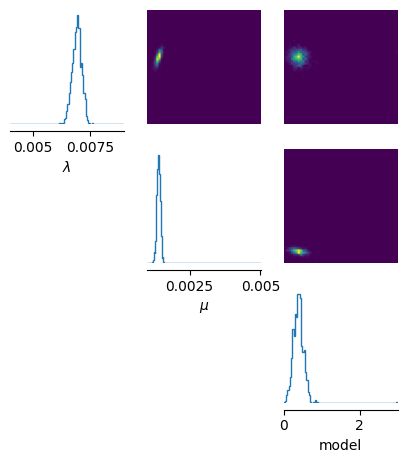

In [29]:
_ = pairplot(
    samples_decim,
    limits=[[lambda_min_prior, lambda_max_prior], [mu_min_prior, mu_max_prior], [0,3]],
    figsize=(5, 5),
    labels=[r"$\lambda$", r"$\mu$", r"model"]
)

/tmp/ipykernel_112805/1195207057.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_samples_decim['model'], hist=True, kde=True,


<Axes: xlabel='model', ylabel='Density'>

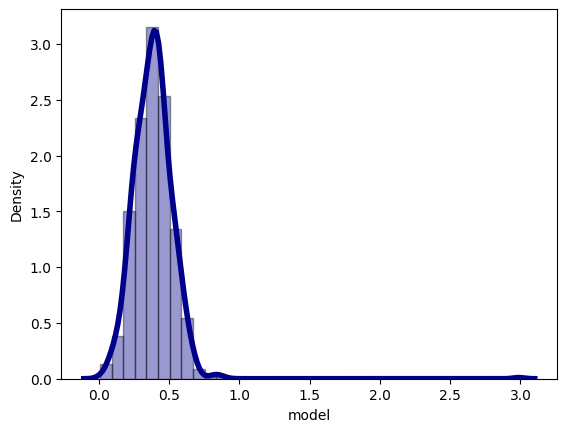

In [30]:
df_samples_decim = pd.DataFrame({'lambda':[x[0] for x in samples_decim.tolist()], 'mu':[x[1] for x in samples_decim.tolist()], 'model':[x[2] for x in samples_decim.tolist()]})
sns.distplot(df_samples_decim['model'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})